# Config

In [2]:
# import torch 
# torch.tensor([1], device="cuda").device
# import gc 
# gc.collect()
# torch.cuda.empty_cache()

import onnx
import onnx_tensorrt.backend as backend
import numpy as np

model = onnx.load("/home/akinwilson/Code/pytorch/torch-deploy/model/model.onnx")
engine = backend.prepare(model, device='CUDA:1')
input_data = np.random.random(size=(32, 3, 224, 224)).astype(np.float32)
output_data = engine.run(input_data)[0]
print(output_data)
print(output_data.shape)

ModuleNotFoundError: No module named 'onnx_tensorrt'

In [16]:
path = "/home/akinwilson/Code/pytorch/dataset/data/000a5b70-dfe9-4bf5-9199-85feb935bfdb.wav"

from scipy.io import wavfile
import base64 

samplerate, data = wavfile.read(path)


txt = base64.b64encode(data)

# with open("bas64.example", "wb") as file:
#     file.write(txt)

import numpy as np 

decoded_wav = base64.decodebytes(txt)
x = np.frombuffer(decoded_wav, dtype=np.int16)
x.shape


(38403,)

In [21]:
import os 

print()

0.5


## Testing onnx runtime

 Issue with CUDA as exection provider. 

 see: 
 
    https://stackoverflow.com/questions/70014477/onnxruntime-not-using-cuda

In [2]:
ort_session.get_providers()

['CPUExecutionProvider']

In [5]:
import onnx 

# path= "/home/akinwilson/Code/pytorch/output/model/DeepSpeech/2022_09_12_11.22.09_AM/export/DeepSpeech.onnx"

# p = "/home/akinwilson/Code/pytorch/output/model/DeepSpeech/2022_09_12_11.22.09_AM/inference/DeepSpeech.pt"

import onnxruntime
import torch 
import time 
import logging 
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

x = torch.randn(1, 1, 48000, device='cpu')
s = time.time()


providers = [ "CPUExecutionProvider", ('CUDAExecutionProvider', {
            'device_id': 0,
            'arena_extend_strategy': 'kNextPowerOfTwo',
            'gpu_mem_limit': 2 * 1024 * 1024 * 1024,
            'cudnn_conv_algo_search': 'EXHAUSTIVE',
            'do_copy_in_default_stream': True,
    }), 
    "TensorrtExecutionProvider"]
logger.info(f"Onnx loading from path: {path}")
ort_session = onnxruntime.InferenceSession(path,
                                           providers=providers)
                                           
logger.info(f"Provider: {ort_session.get_providers()}")
result = ort_session.run(None, {"input_pcm":x.numpy().tolist()})
f = time.time()
logger.info(f"Serving onnx: {f-s}s")
logger.info(result[0][0][0][0])


Provider: ['CPUExecutionProvider']
Serving onnx: 0.6112141609191895s
0.0


2022-09-12 15:05:47.871936188 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:566 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/reference/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [3]:
import onnxruntime as ort
ort.get_all_providers()
ort.get_device()

'GPU'

In [2]:
import onnxruntime
import torch 
import time 
# onnxruntime.get_providers()

/home/akinwilson/.local/share/virtualenvs/pytorch-T3BHxh3q/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: module 'onnxruntime' has no attribute 'get_providers'

In [47]:
p = "/home/akinwilson/Code/pytorch/output/model/DeepSpeech/2022_09_12_11.22.09_AM/inference/DeepSpeech.pt"
import torch 
import time 
# model = torch.load(p)
s= time.time()
model.forward(x)
f = time.time()
print(f"Serving python: {(f-s)* 1e3:.5f}ms")

Serving python: 4.15826ms


In [1]:
from wwv.config import Config 
MODEL_DIR = "/home/akinwilson/Code/pytorch/output/model"
DATA_DIR = "/home/akinwilson/Code/pytorch/data"
LR_RANGE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5][1]
BATCH_SIZE_RANGE = [1,2,32, 64, 128, 256][1]
EPOCH_RANGE = [1, 10, 30, 50, 100, 1000][0]
ES_PATIENCE_RANGE = [1, 10, 20, 100, 200][2]
MODELS = ["VecM5", "Resnet2vec1D","SpecResnet2D", "HSTAT", "DeepSpeech"][-1]
AUDIO_FEATURE_OPT = ["spectrogram", "mfcc", "pcm"][-1]
PRETRAINED_MODEL_NAME_OR_PATH = "facebook/wav2vec2-base-960h"
AUGS = True


params = {
    "audio_duration":3,
    "sample_rate":16000,
    "model_name": MODELS,
    "path": {
        "model_dir": MODEL_DIR,
        "data_dir": DATA_DIR,
        "pretrained_name_or_path": PRETRAINED_MODEL_NAME_OR_PATH
        },
    "fit_param": {"init_lr":LR_RANGE, "weight_decay":0.0001, "max_epochs":EPOCH_RANGE, "gamma": 0.1,"es_patience":ES_PATIENCE_RANGE}, 
    "data_param":{"train_batch_size": BATCH_SIZE_RANGE, "val_batch_size": BATCH_SIZE_RANGE,"test_batch_size": BATCH_SIZE_RANGE}, 
    "audio_feature": AUDIO_FEATURE_OPT,
    "audio_feature_param": { "mfcc":{"sr":16000,"n_mfcc":20,"norm": 'ortho',"verbose":True,"ref":1.0,"amin":1e-10,"top_db":80.0,"hop_length":512,},
                            "spectrogram":{"sr":16000, "n_fft":2048, "win_length":None,"n_mels":128,"hop_length":512,"window":'hann',"center":True,"pad_mode":'reflect',"power":2.0,"htk":False,"fmin":0.0,"fmax":None,"norm":1,"trainable_mel":False,"trainable_STFT":False,"verbose": True },
                            "pcm": {}},
    "augmentation":{'Gain': AUGS, 'PitchShift': AUGS, 'Shift': AUGS},
    "augmentation_param":{"Gain": {  "min_gain_in_db":-18.0,"max_gain_in_db":  6.0,"mode":'per_example',"p":1,"p_mode":'per_example'},
                        "PitchShift": {"min_transpose_semitones": -4.0, "max_transpose_semitones": 4.0,"mode":'per_example',"p":1,"p_mode":'per_example',"sample_rate":16000,"target_rate": None,"output_type": None,},
                        "Shift":{ "min_shift":-0.5,"max_shift": 0.5,"shift_unit":'fraction',"rollover": True,"mode":'per_example',"p":1,"p_mode": 'per_example',"sample_rate": 16000,"target_rate":None,"output_type":None}},
    }

cfg = Config(params)
from wwv.train import main
main(cfg)
# from pprint import pprint 
# pprint(cfg.__dict__)

/home/akinwilson/.local/share/virtualenvs/pytorch-T3BHxh3q/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
--------------------> Augmentations to be applied: ['Gain', 'PitchShift', 'Shift']
--------------------> Augmentations to be applied: ['Gain', 'PitchShift', 'Shift']
--------------------> Augmentations to be applied: ['Gain', 'PitchShift', 'Shift']
--------------------> Augmentations to be applied: ['Gain', 'PitchShift', 'Shift']
--------------------> Augmentations to be applied: ['Gain', 'PitchShift', 'Shift']
--------------------> Augmentations to be applied: ['Gain', 'PitchShift', 'Shift']
--------------------> Features to be extracted: pcm
--------------------> Features to be extracted: pcm
--------------------> Features to be extracted: pcm
--------------------> Features to be extracted: pcm
-

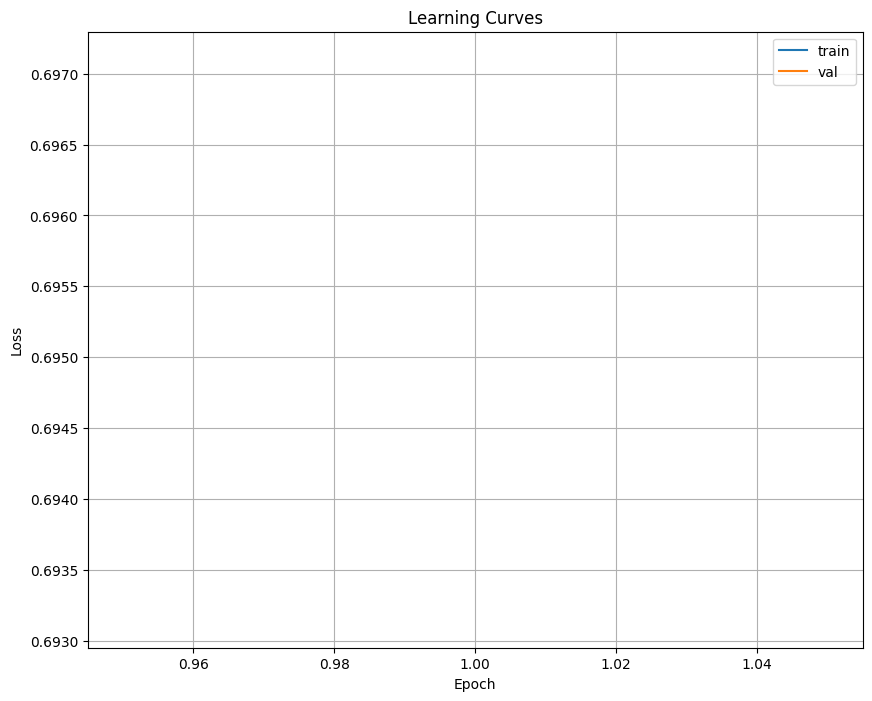

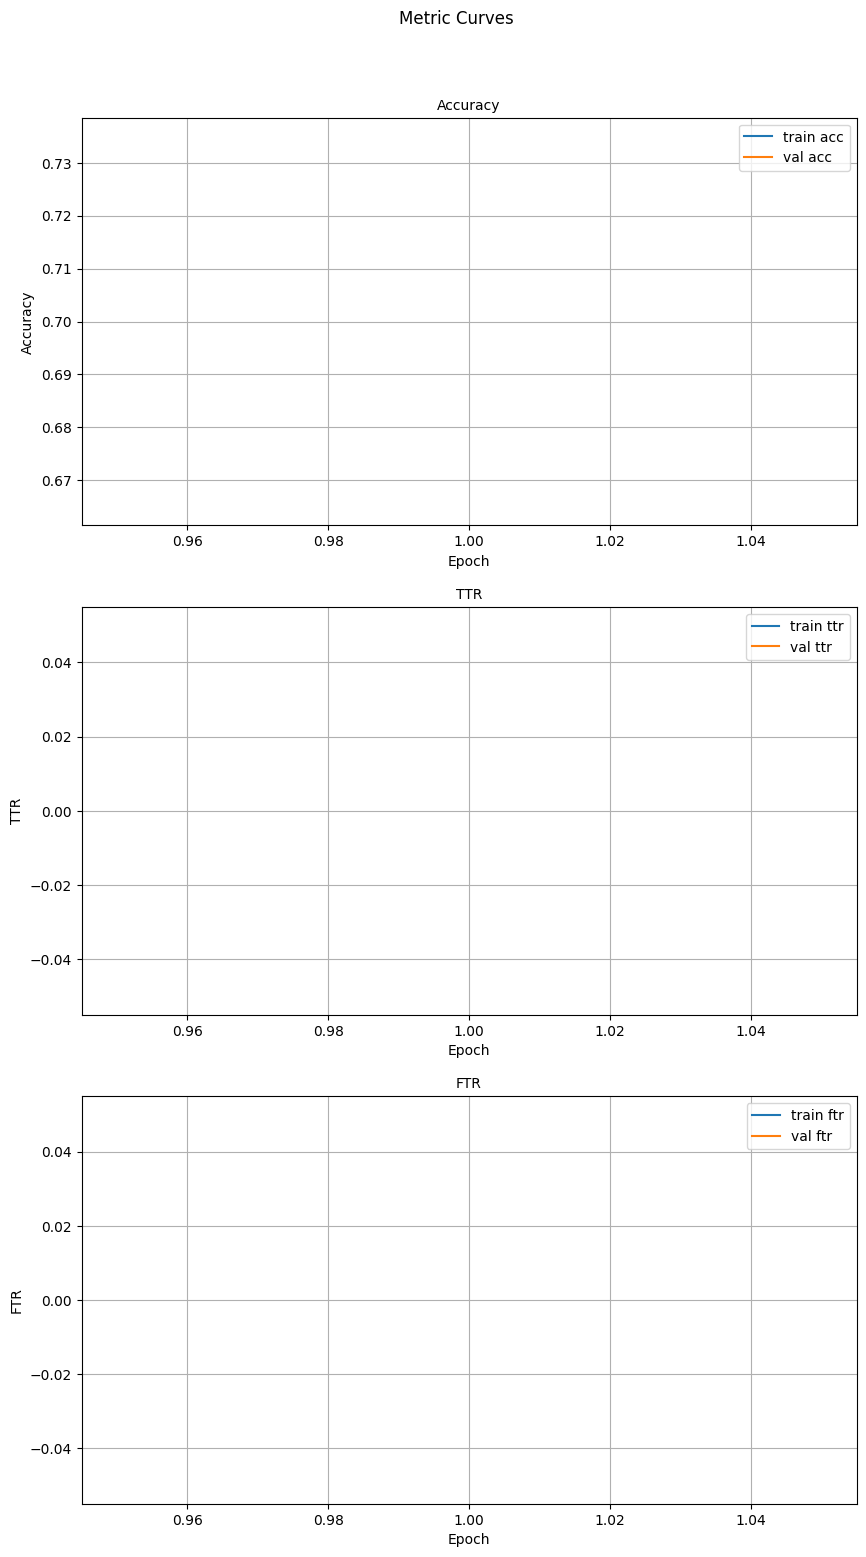

In [2]:
from wwv.train import main
main(cfg)
# from wwv.architecture import Architecture
# import torch 
# # m = Architecture(cfg, True).to("cuda")
# m(torch.rand(1,1,48000, device="cuda"))


In [ ]:

import torch.nn as nn 
from pathlib import Path 
import json 
import torch 

from wwv.architecture import Architecture 
from wwv.layer import AugmentationManager 


# device = "cuda" if torch.cuda.is_available() else "cpu"


arc = Architecture(cfg, True)
arc

# arc.processing_layer[1] = AugmentationManager(cfg, False)
# arc
# # am = AugmentationManager(cfg, True)
# am
# am = AugmentationManager(cfg, False)
# am



In [ ]:
from wwv.architecture import Architecture


m = Architecture(cfg)
print(m.training)

import onnx


class OnnxExporter:

    def __init__(self, model, model_name, output_dir):
        
        self.model_name = model_name 
        self.model = model
        self.output_dir =output_dir
        self.model.eval()
        assert not self.model.training, "Model not in inference mode before exporting to onnx format"

        # Input to the model
        batch_size = 1
        self.x_in = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
        self.x_out = self.model(self.x_in)
        self.onnx_model_path=None



    def verify(self):
        model = onnx.load(self.onnx_model_path)
        logger.info(onnx.checker.check_model(model))

            

    # Export the model
    def __call__(self):
        output_path = self.output_dir / f"{self.model_name}.onnx"

        torch.onnx.export(self.model,                        # model being run
                        self.x_in,                           # model input (or a tuple for multiple inputs)
                        output_path,           # where to save the model (can be a file or file-like object)
                        export_params=True,        # store the trained parameter weights inside the model file
                        opset_version=10,          # the ONNX version to export the model to
                        do_constant_folding=True,  # whether to execute constant folding for optimization
                        input_names = ['input'],   # the model's input names
                        output_names = ['output'], # the model's output names
                        dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                        'output' : {0 : 'batch_size'}})
        self.onnx_model_path = output_path
        self.verify()
        return self 

# import torch 
    
trained_model =  m.load_state_dict(torch.load("/home/akinwilson/Code/pytorch/output/model/VecM5/2022_09_10_07.25.21_PM/state/val-acc-0.80.pt"))
    

In [ ]:
import time 
import numpy as np 

class Predictor:
    def __init__(self, model_path, device="cuda"):
        self.device = device
        self.model = torch.load(model_path, map_location=device)
    
    def predict(self, x:torch.tensor)-> np.ndarray:
        """
        param:
            x: x.shape = (batch_dim, channel_dim, time_series)     
                    e.g. (1,         1,        max_sample_len)
        return:
            prob 
        """
        # make sure the tensor is on the same device as the model 
        x = x.to(self.device)
        with torch.no_grad(): # dont do gradient calcs
            logits = self.model(x)
            # convert to probabilities and squueze inplace
            prob = torch.distributions.Bernoulli(logits=logits).probs.squeeze_()
            # detach from graph
            raw_prob = prob.cpu().numpy()
            return raw_prob

    
    def __call__(self, x:torch.tensor)-> float:
        return self.predict(x)
        

x = torch.rand(2,1,48000)
p = "/home/akinwilson/Code/pytorch/output/model/VecM5/2022_09_11_09.17.21_AM/inference/VecM5.pt"

s= time.time()
predictor = Predictor(p)
e= time.time()
print(f"Loading model to GPU: {e-s}s")

s = time.time()
prob = predictor(x)

print(f"Prob: {prob}")
print(f"Prob: {type(prob)}")
e = time.time()
print(f"Inference time GPU: {e-s}s")




In [ ]:
prob

In [ ]:
prob

In [ ]:

import torch 
p = "/home/akinwilson/Code/pytorch/output/model/VecM5/2022_09_11_09.17.21_AM/inference/VecM5.pt"
# with torch.no_grad():
x = torch.rand(1,1,48000, device="cuda")
ww_p = torch.distributions.Bernoulli(logits=torch.load(p)(x)).probs.squeeze_()
print(ww_p)





# class Predictor:


In [17]:
ort_session.get_providers()

['CPUExecutionProvider']

In [ ]:
?torch.onnx.export

In [ ]:
?ort_session.run

## Normalisation

In [ ]:
# # PitchSift works alone 
# # audio feature spectogram not working
# import logging 
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)
# logger.addHandler(logging.StreamHandler())

# import json 
# import torch
# import torch.nn as nn 
# from nnAudio import features
# import numpy as np 
# from torch_audiomentations import Compose, Gain, PitchShift, Shift, Identity
# from torchvision import  transforms


# class Standardisation(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         '''
#         Class standardises input using statistic gathering during preprocessing
#         '''
#         stats_path = cfg.path['data_dir'] + "/stats.json"
#         with open(stats_path, "r") as file:
#             stats_dict = json.loads(file.read())
#         for k in  stats_dict:
#             setattr(self, k, torch.Tensor([stats_dict[k]]))

#     def forward(self, x:torch.Tensor) -> torch.Tensor:
#         return ( x - self.mean ) / self.var**(1/2)




# class AugmentationManager(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         '''
#         Augmentation class prodvides a transformation pipeline to be 
#         appplied to the data during loading. These transforms should not 
#         be part of the architecture, but rather the transforms of the data 
#         '''
#         self.cfg =cfg 
#         self.transforms = self.compose_augmentations()

#     def compose_augmentations(self):
#         augs = [k for (k,v) in self.cfg.augmentation.items() if v]
#         augs_params = [v for (k, v) in self.cfg.augmentation_param.items() if k in augs]
#         func_dict = {
#             "Gain":Gain,
#             "PitchShift":PitchShift,
#             "Shift":Shift
#             }
#         print(f"{'-'*20}> Augmentations to be applied: {augs}")

#         transforms_list = [func_dict[k](**v) for (k,v) in zip(augs,augs_params)]
#         if self.training:
#             # apply augmentations only during trainin
#             transforms = Compose( transforms_list)
#         else:
#             transforms = Compose([Identity(mode='per_example', p=1)])
#         return transforms

#     def forward(self, x):
#         return self.transforms(x)



# class ProcessingLayer(nn.Module):

#     def __init__(self,cfg):
#         super().__init__()
#         self.cfg =cfg
#         layers = []
#         kwargs = cfg.audio_feature_param[cfg.audio_feature]
#         if cfg.audio_feature == "spectrogram":
#             layers.append(features.MelSpectrogram(**kwargs))
#         elif cfg.audio_feature == "mfcc":
#             layers.append(features.MFCC(**kwargs))
#         # resize inputs
#         # layers.append(transforms.RandomResizedCrop(224))
#         self.net = torch.nn.Sequential(*layers)
#         logger.info(f"{'-'*20}> Features to be extracted: {cfg.audio_feature}")
#         logger.info(f"{'-'*20}> Feature dimensions: {cfg.processing_output_shape}")

#     def forward(self, x:torch.Tensor) -> torch.Tensor:
#         return self.net(x)

import torch 
from wwv.layer import AugmentationManager, Standardisation, ProcessingLayer
        
train_pipeline = torch.nn.Sequential(*[Standardisation(cfg),  AugmentationManager(cfg), ProcessingLayer(cfg)])
# train_pipeline(torch.rand(10,1,3*16000)).shape

# train_pipeline.training = False
# x = torch.randint(0, 6, (10,1,3*16000))
# x_val = train_pipeline(x)


# Model definition

In [ ]:
from wwv.architecture import Architecture 




In [ ]:


# feature_extractor: torch.nn.Module,
#  encoder: torch.nn.Module,
#  aux: Optional[torch.nn.Module] = None)
x_in = torch.randint(0, 6, (10,1,3*16000))
x_out = Wav2vec(cfg)(x_in)
x_out.shape
# torch.allclose(x_in,x_out)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta 
import torch

# class ResNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model_ft = models.resnet18(pretrained=True)
#         self.feature_extract= False
#         self.num_ftrs = self.model_ft.fc.in_features
#         self.model_ft.fc = nn.Linear(self.num_ftrs, 1)

#         self.input_size = 224

#     def forward(self,x):
#         # account for channels 
#         x = torch.stack([x,x,x], dim=1)
#         return F.logsigmoid(self.model_ft(x))




class Architecture(nn.Module):

    def __init__(self,cfg, n_input=1, n_output=1, stride=16, n_channel=32):
        super().__init__()
        self.cfg = cfg 
        # preprocessing layers 
        self.processing_layer = torch.nn.Sequential(*[Standardisation(),
                                                      AugmentationManager(cfg),
                                                       ProcessingLayer(cfg)])
        #layers of the models

        self.extractor = Wav2vec(cfg)
        self.model = M5(n_input=1, n_output=1, stride=16, n_channel=32)
        
        logger.info(f"{'-'*20}> Model name: {self.model.__class__.__name__}")
        logger.info(f"{'-'*20}> Model layers: {self.model}")
        logger.info(f"{'-'*20}> Trainingable params: {self.count_trainable_params()}")

    def count_trainable_params(self):
        traininable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        processing_trainable_params =  sum(p.numel() for p in self.processing_layer.parameters() if p.requires_grad)
        return  traininable_params + processing_trainable_params

        
    def forward(self, x):
        x = self.processing_layer(x)
        x = self.extractor(x)
        logits = self.model(x)
        return logits  


network = Architecture(cfg)
x = torch.randint(0, 6, (1,1,3*16000))

network.forward(x).shape

In [ ]:
import numpy as np 
from pathlib import Path 

onnx_model_path = "/home/akinwilson/Code/pytorch/output/model/VecM5/2022_09_10_08.47.24_PM/export/VecM5.onnx"
ort_session = onnxruntime.InferenceSession(str(onnx_model_path),
                                            providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
# compute ONNX Runtime output prediction
logger.info(f"ort_session: {ort_session.__dict__}")
logger.info(f"ort_session.get_inputs(): {ort_session.get_inputs()}")
ort_inputs = {ort_session.get_inputs()[0].name: self.x_in}

logger.info(f"ort_inputs {ort_inputs}")
ort_outs = ort_session.run(None, ort_inputs)
# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(self.to_numpy(self.x_out), ort_outs[0], rtol=1e-03, atol=1e-05)
logger.info("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [ ]:
{'y_hat': tensor([0., 0., 1., 1.]),
 'y': tensor([0., 1., 1., 0.]),
 'tp': 1,
 'tn': 1,
 'fn': 1,
 'fp': 1,
 'acc': 0.5,
 'ttr': 0.5,
 'ftr': 0.5}

In [ ]:
import pandas as pd 
df_path= "/home/akinwilson/Code/pytorch/data/data.csv"
df = pd.read_csv(df_path)
df.head()

# Dataloader 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

# Fitting routine

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path 


# train_losses, val_losses
class Plotter:
    def __init__(self,output_dir):
        self.output_dir = output_dir
        self.metric_title = {
            "val_acc":"Validation accuracy", 
                "val_ttr":"Validation TTR", 
                "val_ftr": "Validation FTR",
                "train_acc":"Training accuracy", 
                "train_ttr":"Training TTR", 
                "train_ftr": "Training FTR"
            }
        self.metric_key = ["val_acc", "val_ttr", "val_ftr",
                "train_acc", "train_ttr", "train_ftr"]
    def get_loss(self,losses):
        x = [ e for (e,_) in losses]
        y = [ l for (_,l) in losses] 
        return x, y 

    def get_metrics(val_metrics,name:str):
        y = [x[name] for x in val_metrics]
        x = np.arange(1, len(y)+ 1,1)
        return x, y 

    def plot_learning_curves(self, train_losses, val_losses):
        fig = plt.figure(figsize=(10,8))
        plt.title("Learning curves")
        xt,yt = self.get_loss(train_losses)
        plt.plot(xt, yt, label = "train")
        xv,yv = self.get_loss(val_losses)
        plt.plot(xv, yv, label = "val")
        plt.grid()
        plt.legend()
        plt.savefig(self.output_dir / "lc.png")

    def plot_metric_curves(self, ):

        fig, axs = plt.subplots(len(self.metric_key), 1,  figsize=(8, 20))
        fig.suptitle('Validation metrics', fontsize=12)
        for (ax, name) in zip(axs, self.metric_key):
            x, y = self.get_metrics(val_metrics, name)
            ax.plot(x,y, label=name)
            ax.set_title(self.metric_title[name], size=10)
            ax.set_xlabel("Epoch")
            ax.grid()

        plt.savefig(self.output_dir / "metric.png")

In [ ]:
val_metrics

In [ ]:
def get_metrics(val_metrics,name:str):
    y = [x[name] for x in val_metrics]
    x = np.arange(1, len(y)+ 1,1)
    return x, y 


metric_names = ["val_acc", "val_ttr", "val_ftr",
                "train_acc", "train_ttr", "train_ftr"]

metric_title = {"val_acc":"Validation accuracy", 
                "val_ttr":"Validation TTR", 
                "val_ftr": "Validation FTR",
                "train_acc":"Training accuracy", 
                "train_ttr":"Training TTR", 
                "train_ftr": "Training FTR"}

fig, axs = plt.subplots(len(metric_names), 1,  figsize=(8, 20))
fig.suptitle('Validation metrics', fontsize=12)


for (ax, name) in zip(axs, metric_names):
    x, y = get_metrics(val_metrics, name)
    ax.plot(x,y, label=name)
    ax.set_title(metric_title[name], size=10)
    ax.set_xlabel("Epoch")
    ax.grid()

In [ ]:
# def pad_sequence(x:torch.Tensor, cfg):
#     '''
#     Pads audio file upto length pad_to_len
#     returns padded audiofile 
#     '''
#     if x.size()[-1] > cfg.max_sample_len: # case longer than pad_to_len
#         x_new = x[:,:cfg.max_sample_len] 
#     else: # case shorted than pad_to_len
#         padding = torch.tensor([0.0]).repeat([1,cfg.max_sample_len - x.size()[-1]])
#         x_new = torch.hstack([x, padding])
        
#     assert x_new.size()[-1] == cfg.max_sample_len, f"Incorrect padded length, Should be {cfg.max_sample_len}, got {x_new.size()[-1]}"
    
#     return x_new # (1 ,1 , pad_to_len)

In [ ]:
x

In [ ]:
pm.forward(torch.randn(1,3*16000)).shape

cfg.processing_output_shape



class MnistModel(torch.nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.processing_layer = get_preprocessing_layers(cfg)
        #layers of the model
        self.l1 = torch.nn.Linear(cfg.processing_output_shape, 512)
        self.l2 = torch.nn.Linear(512, 10)
        self.flat = torch.nn.Flatten()
 
    def forward(self, x):
        #one forward pass
        out = self.flat(x)
        out = F.relu(self.l1(out))
        out = self.l2(out)
        return out
 
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
 
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        _, pred = torch.max(out, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()]

        